### 時系列データ分析  
時系列を含むデータに対しての解析方法、および前処理段階で用いられる「時系列データ分析」の手法について解説  
https://qiita.com/tk-tatsuro/items/16ce74fc954b5a58df00

###  時系列データとは  
時系列データとは、時間の順序にしたがって並べられたデータのことをいいます。
例えば、株価の値動き、気温や降水量などの気象情報、交通量の推移などがこれにあたります。  

### 時系列データがもつ情報  
時系列データには大きく分けて「傾向変動」「季節変動」「循環変動」「不規則変動」の４つの情報（要因）を持っています。ひとつひとつ解説していきます。

#### 1.傾向変動（トレンド）  
トレンドとは、時系列の⻑期的傾向のことです。時間の経過とともに増加・減少する傾向とも言えます。
トレンドの推定方法には「移動平均」などがあります。詳しくは後述します。

#### 2.季節変動（シーズナル）  
季節変動とは、（通常）1年を周期とする規則的な変動のことです。

#### 3.循環変動（サイクル）  
傾向変動より短期的で、周期的に繰り返される変動のことです。

#### 4.不規則変動（ノイズ）  
トレンド、季節変動、循環変動では説明できない、短期的かつ不規則な変動のことです。

これらを確認するため「季節調整」という手法をまずは簡単に見ていきましょう。

In [27]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline

import yfinance as yf

[*********************100%%**********************]  1 of 1 completed


                 Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2012-04-02   2.488667   2.531333   2.435333   2.438667   2.438667   15429000
2012-04-03   2.446667   2.564667   2.444667   2.534000   2.534000   16471500
2012-04-04   2.351333   2.366000   2.312667   2.333333   2.333333   67227000
2012-04-05   2.340000   2.362667   2.294000   2.298667   2.298667   22641000
2012-04-09   2.273333   2.286000   2.206667   2.210000   2.210000   24835500
...               ...        ...        ...        ...        ...        ...
2017-03-24  17.046667  17.592667  17.000668  17.544001  17.544001   84709500
2017-03-27  17.373333  18.038000  17.316668  18.014668  18.014668   93462000
2017-03-28  18.468000  18.712000  18.333332  18.496668  18.496668  119814000
2017-03-29  18.556000  18.639999  18.369333  18.492001  18.492001   55143000
2017-03-30  18.535999  18.799999  18.480667  18.528000  18.528000   6222600

<Axes: xlabel='Date'>

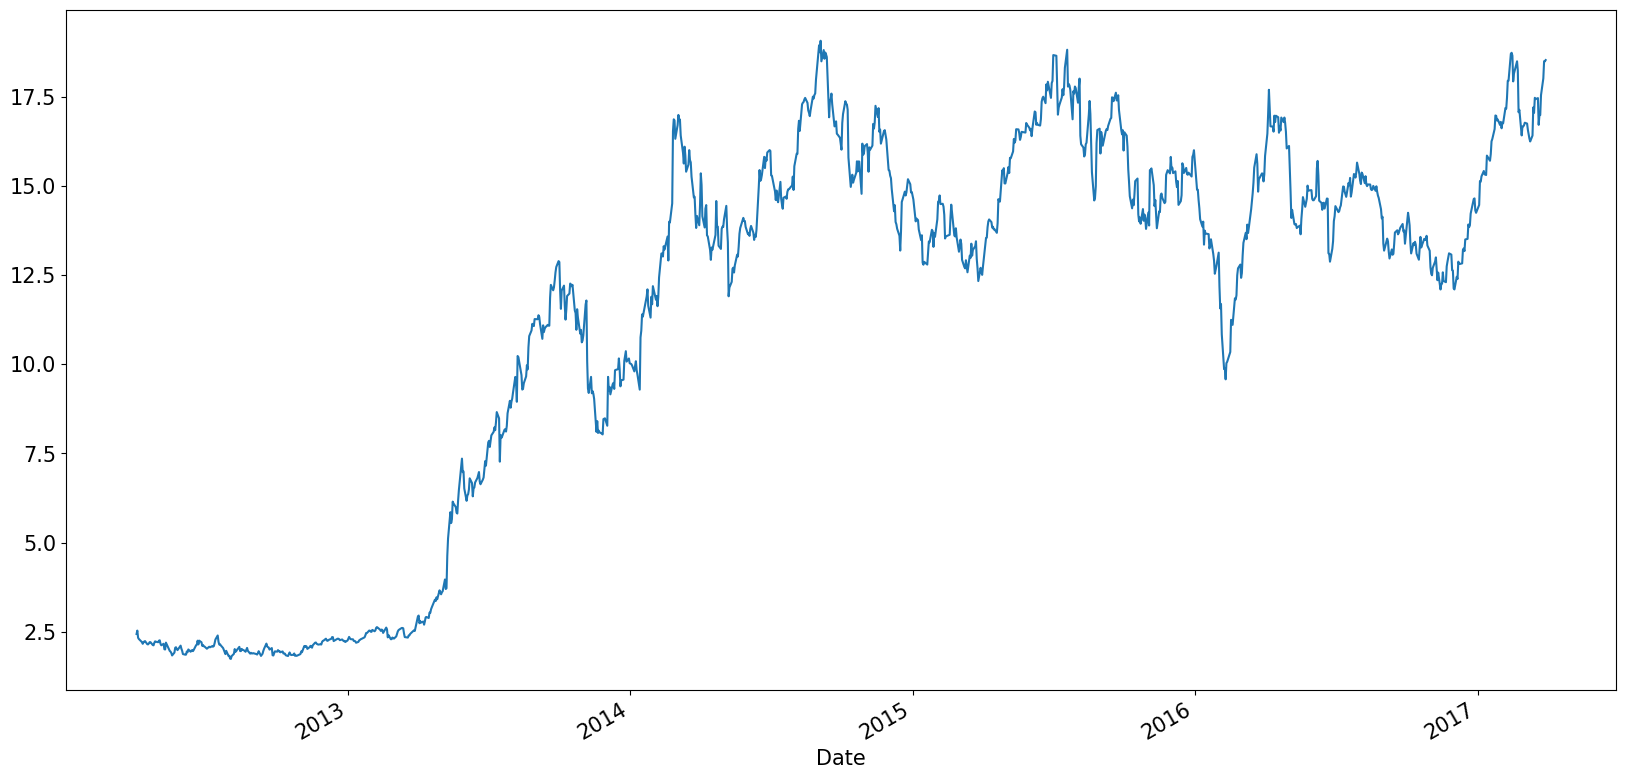

In [28]:
stock_df = yf.download('TSLA', start='2012-04-01', end='2017-03-31')
print(stock_df)
stock_df['Close'].plot()

#### 成分分解（季節調整）

In [29]:
# Dataをインデックスに設定
stock_df = stock_df.reset_index()
time_series = stock_df.copy()
time_series['Date'] = pd.to_datetime(stock_df['Date'])
time_series = time_series.set_index(['Date']).sort_index(ascending=True)

In [30]:
# 表示サイズ調整
plt.rcParams["figure.figsize"] = [20,10]
plt.rcParams["font.size"] = 15

# 原系列、傾向（トレンド）、季節変動（季節性）、不規則変動（残差）
def plt_seasonal_decompose(df, col_name, period):
    res = sm.tsa.seasonal_decompose(df[col_name], period=period)
    fig = res.plot()
    plt.show()

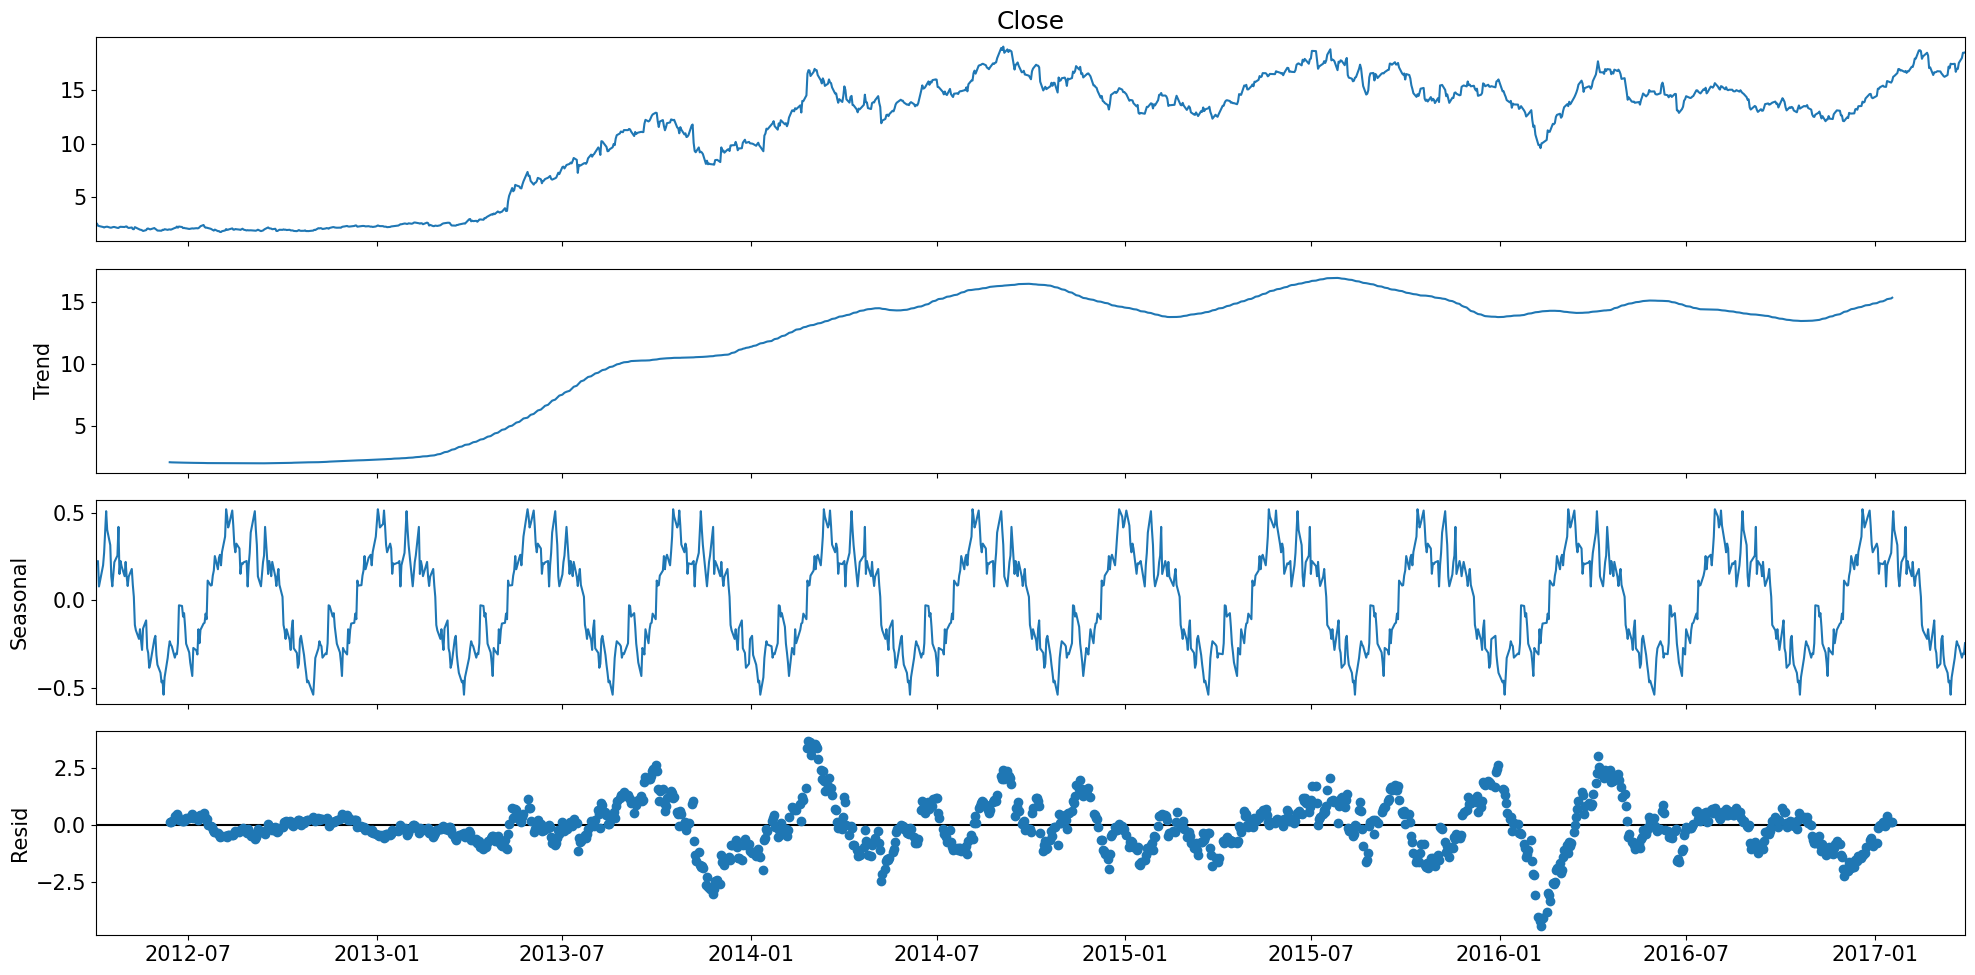

In [31]:
# 原系列をインプットして確認
plt_seasonal_decompose(time_series, col_name='Close', period=100)

1番目のグラフが原系列、2番目のグラフが傾向変動（Trend）、3番目のグラフが季節変動（Seasonal）、4番目のグラフが不規則変動（Resid（残差））を表しています。

### 時系列データにおける重要な概念  
時系列データ分析を始める前に、まずは時系列データにおける重要な概念を解説していきます。
「定常性」「単位根過程」「自己共分散」の３つを紹介します。

#### 1.定常性  
定常性とは、時間経過による影響を（強く）受けない状態のことです。
また、定常過程とは、その確率的な変動の性質が、各時点に依存せず一定であるような確率過程のことを言います。
具体的には、各期の平均が普遍であるとみなせる、上昇（下降）の傾向がないデータのことです。
例えば、携帯アラームの周波数など、平均0の周辺で一定の分散をもってランダムに振動を続けるデータは、（弱）定常性があると言えます。反対に、明らかな上昇傾向が存在し変化し続けている株価の値動きなどは、定常性があるとは言えません。

時系列データについての説明のため、先に基本の4成分（傾向変動等）に触れましたが、（成分分解をする前に）そもそも定常性があるのかを確認する必要があるため、まずは定常性の条件である「平均」と「分散」を確認しておきましょう。

In [39]:
print(stock_df['Close'].mean())
print(stock_df['Close'].var())

11.386275785540244
29.584653828104653


（弱）定常性の定義は「平均0の周辺で一定の分散をもってランダムに振動を続けるデータ」でしたが、Close（終値）はかなりばらつきのあるデータと言えるでしょう。後ほど、定常性となりえなかった要因の成分を取り除き、再度確認することにしましょう。



#### 2.単位根過程とは  
単位根過程の定義としては、
が非定常過程、また差分系列　　
が定常過程である時、
は単位根過程である、です。※
は差分を表します。
データの原系列は非定常だけれど、差分を取ると（弱）定常になるようなデータとも言えます。

最も代表的な単位根過程として「ランダムウォーク」があります。
ランダム・ウォーク過程とは、
 の系列が、
　と表すことができます。

#### 3.自己共分散  
ある時系列 
 に関して、各時点t における期待値を E[
]= μtとしたとき、時点差
jにおける
yt　と
y
の共分散を、時差jの自己共分散といいます。
つまり、同一の時系列データにおける異なる時点間での共分散を指します。
（※
 = Covariance（共分散）、
 = Expect（期待値））



### 時系列データ分析とは  
それでは時系列データ分析について解説していきましょう。
時系列データ分析とは、ある一定間隔の時間に対して観測されているデータの周期性や傾向から将来を予測する手法のことを言います。これにより近い将来を把握し、施策の検討や対策を打つことが可能となります。

#### 時系列データ分析の目的
時系列データ分析には、大きく分けて下記の３つの目的があります。  
1.データの可視化  
2.情報の抽出  
3.将来の予測  
それぞれ具体的に見ていきましょう。

#### 1.データの可視化  
データの特徴を捉える為、「周期性」および「時間的な相関」を可視化していくことがあります。

#### ①周期性  
周期性（周期的変動）とは、時系列が⼀定の間隔で同じような変動を繰り返す成分、またはその状態を指します。
周期性を可視化する方法として「コレログラム」というものがあります。
コレログラムとは、ラグと自己相関を表したグラフです。
ラグとは、元データからどれほど時間をずらしているかを表す指標のことです。
つまり、元データxから時間をずらしたデータyとの相関係数を表すグラフであり、横軸にラグ、縦軸に自己相関をとります。
青で塗られた領域は、データが無相関としたときの95%信頼区間で、この領域の外にある場合この仮定は棄却され、相関があると判断できます。

In [40]:
# 表示サイズ調整
plt.rcParams["figure.figsize"] = [20,2]
plt.rcParams["font.size"] = 10

# コレログラム
def correlogram(cicle, lags, df, feature):
    sm.graphics.tsa.plot_acf(df.resample(cicle)[feature].sum(), title=feature, lags=lags)

ValueError: could not broadcast input array from shape (6,) into shape (8,)

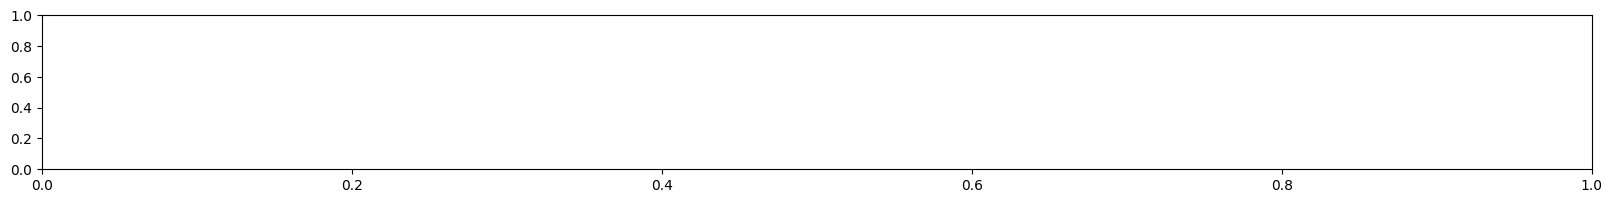

In [41]:
# まずは原系列をインプットして確認
correlogram(cicle='Y', lags='7', df=time_series, feature='Close') # 年ベース
correlogram(cicle='M', lags=str(12*6), df=time_series, feature='Close') # 月ベース
correlogram(cicle='D', lags=str(30*12*6), df=time_series, feature='Close') # 日ベース

/home/bayes/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 32066 (\N{CJK UNIFIED IDEOGRAPH-7D42}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/bayes/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 20516 (\N{CJK UNIFIED IDEOGRAPH-5024}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/bayes/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 31227 (\N{CJK UNIFIED IDEOGRAPH-79FB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/bayes/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 21205 (\N{CJK UNIFIED IDEOGRAPH-52D5}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/bayes/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24179 (\N{CJK UNIFIED IDEOGRAPH-5E73}) missin

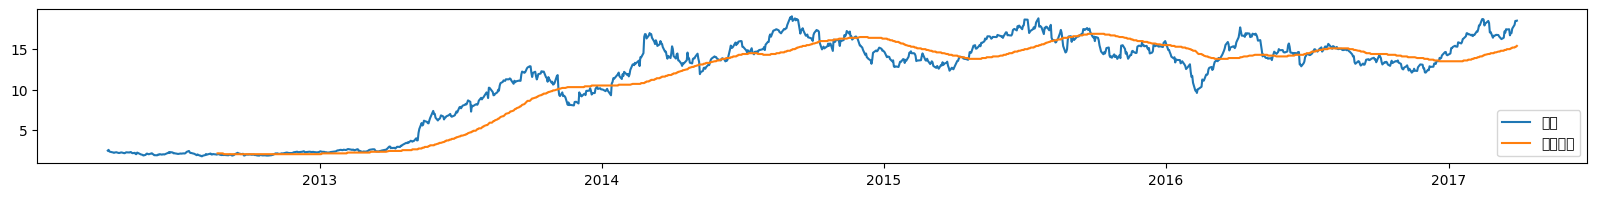

In [42]:
# インデックスに['Date']（時間情報）を設定
stock = stock_df.copy()
stock["Date"] = pd.to_datetime(stock['Date'])
stock = stock.set_index(['Date']).sort_index(ascending=True)

# 移動平均
stock['Close_move_mean'] = stock['Close'].rolling(100).mean().round(1)
plt.plot(stock['Close'], label='終値')
plt.plot(stock['Close_move_mean'], label='移動平均')
plt.legend(loc='lower right')
plt.show();


In [43]:
def adf_test(series):
    adf_df = pd.DataFrame(
        [
            stattools.adfuller(series)[1]
        ],
        columns=['P値']
    )
    adf_df['P値'] = adf_df['P値'].round(decimals=3).astype(str)
    print(adf_df)

# 原系列のp値を算出
adf_test(series=time_series['Close'])

# 結果：p値 = 0.815


NameError: name 'stattools' is not defined

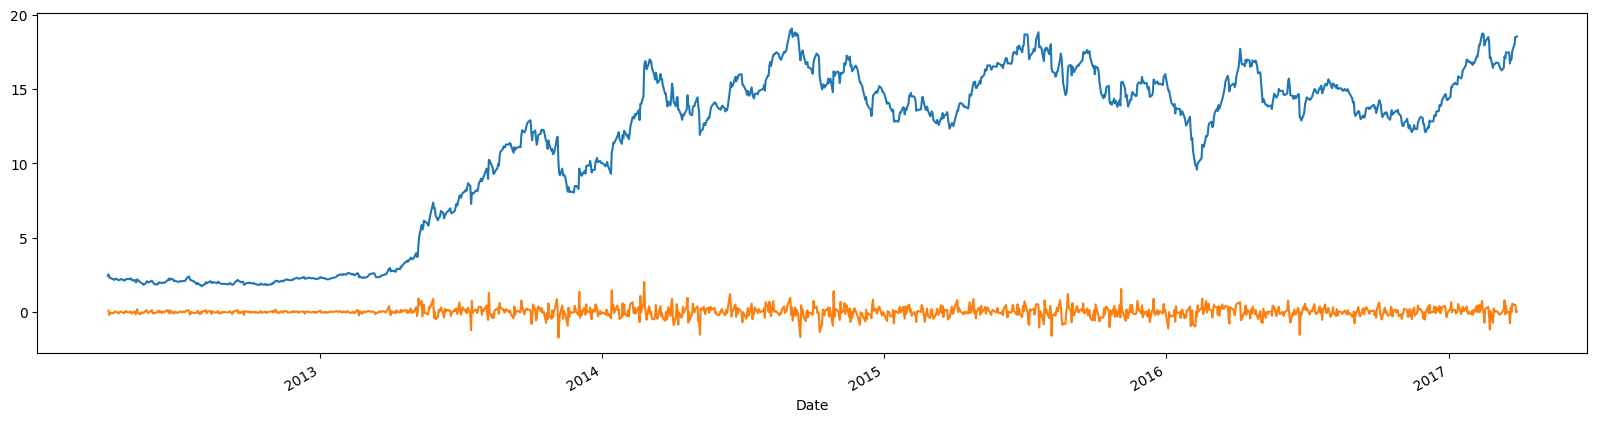

In [44]:
# Dataをインデックスに設定
time_series = stock_df.copy()
time_series["Date"] = pd.to_datetime(stock_df['Date'])
time_series = time_series.set_index(['Date']).sort_index(ascending=True)

# 原系列のプロット
plt.plot(time_series['Close'])

# 差分変換後のプロット
time_proc = time_series.copy()
Passengers_diff_c = time_proc["Close"].diff(periods = 1)
Passengers_diff_c.plot(figsize=[20,5]);


In [46]:
import numpy as np

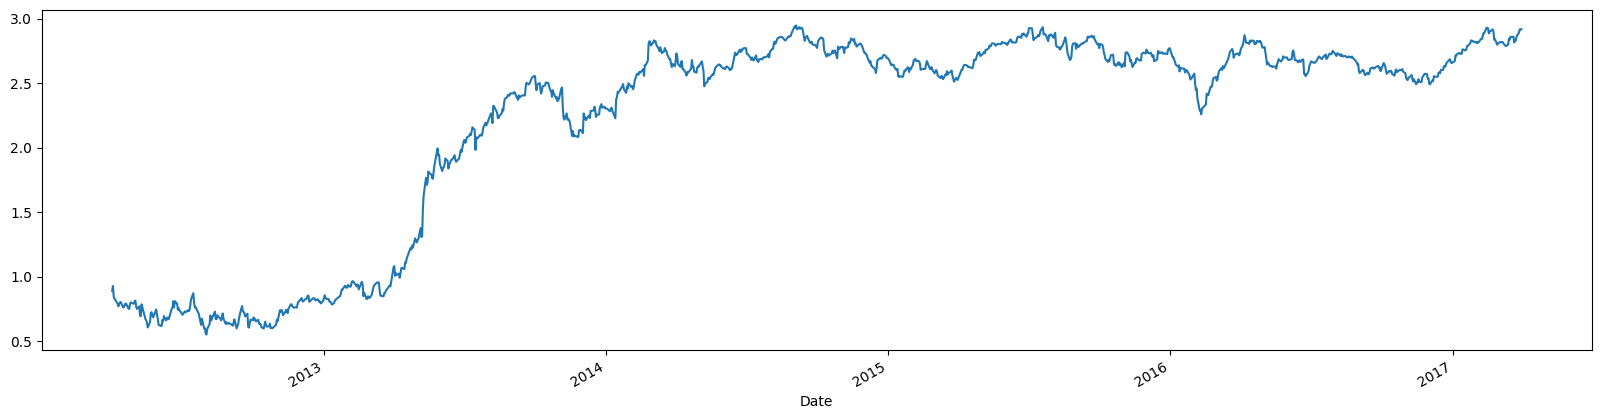


Caching the list of root modules, please wait!
(This will only be done once - type '%rehashx' to reset cache!)



/home/bayes/.local/lib/python3.10/site-packages/IPython/core/completerlib.py:149: UserWarning: using rootmodules_cache requires you to install the `pickleshare` library.
  ip.db['rootmodules_cache'] = rootmodules_cache


In [47]:
Passengers_log_c = np.log(time_proc["Close"])
Passengers_log_c.plot(figsize=[20,5]);


In [48]:
Passengers_log_c.mean()
Passengers_log_c.var()

# 平均：4.48285833956542
# 分散：0.9894592908040513


0.6104235247369306